In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
import nibabel as nb
from nighres.io import io_mesh

### Extracting DRN coordinates from cell atlas

In [35]:
# load some of the cell positions
positions = pd.read_csv('/home/julia/data/gradients/atlas/epfl_cell_atlas/positions.txt', 
                        chunksize=10000, 
                        usecols=[0,1,2,3,4], 
                        header=None, 
                        skiprows=1,
                        names=['x', 'y', 'z', 'region', 'type'])

In [36]:
drn_cells = pd.DataFrame()
for chunk in positions:
    drn_cells = drn_cells.append(chunk.loc[chunk['region'] == 872])

### Extracting DRN positions from mesh

In [37]:
drn_mesh = pd.read_csv('/home/julia/data/gradients/atlas/epfl_cell_atlas/mesh_872.csv')

### Extracting the coordinates from the image

In [60]:
mcc = MouseConnectivityCache(manifest_file='mouse_connectivity_manifest.json')
drn_mask, drn_info = mcc.get_structure_mask(872, '/home/julia/data/gradients/atlas/allen_api/drn.nrrd')

2019-08-06 12:23:49,817 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/structure_masks/structure_masks_25/structure_872.nrrd


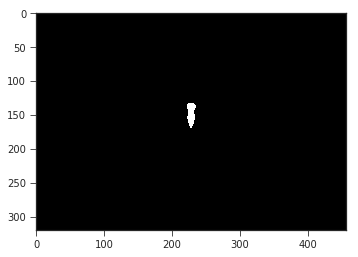

In [78]:
slice_idx = 393
plt.imshow(drn_mask[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=1)

In [40]:
drn_img = np.where(drn_mask==1)

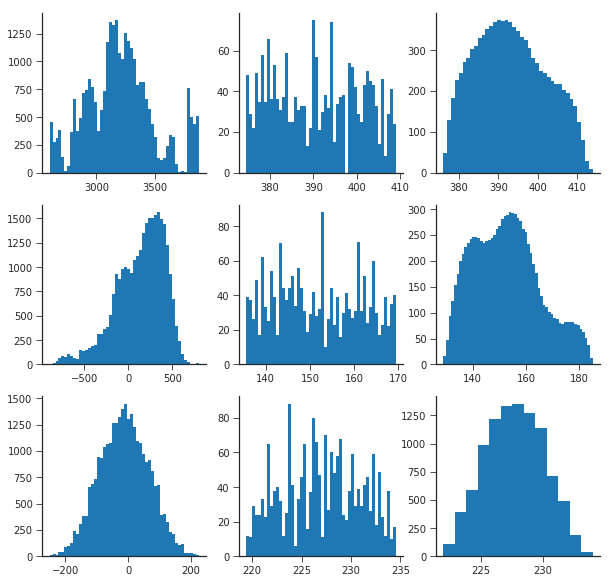

In [120]:
sns.set_style('ticks')
fig = plt.figure(figsize=(10,10))
fig.add_subplot(3,3,1)
plt.hist(drn_cells['x'], bins=50)
fig.add_subplot(3,3,2)
plt.hist(drn_mesh['Points:0'], bins=50)
fig.add_subplot(3,3,3)
plt.hist(drn_img[0], bins=39)

fig.add_subplot(3,3,4)
plt.hist(drn_cells['y'], bins=50)
fig.add_subplot(3,3,5)
plt.hist(drn_mesh['Points:1'], bins=50)
fig.add_subplot(3,3,6)
plt.hist(drn_img[1], bins=57)

fig.add_subplot(3,3,7)
plt.hist(drn_cells['z'], bins=50)
fig.add_subplot(3,3,8)
plt.hist(drn_mesh['Points:2'], bins=50)
fig.add_subplot(3,3,9)
plt.hist(drn_img[2], bins=13)

sns.despine()

### Compute center from whole brain image

In [156]:
x0 = (drn_mask.shape[0])/0.025/2
y0 = (drn_mask.shape[1])/0.025/2
z0 = drn_mask.shape[2]/0.025/2

In [162]:
drn_mask.shape[2]/2


228.0

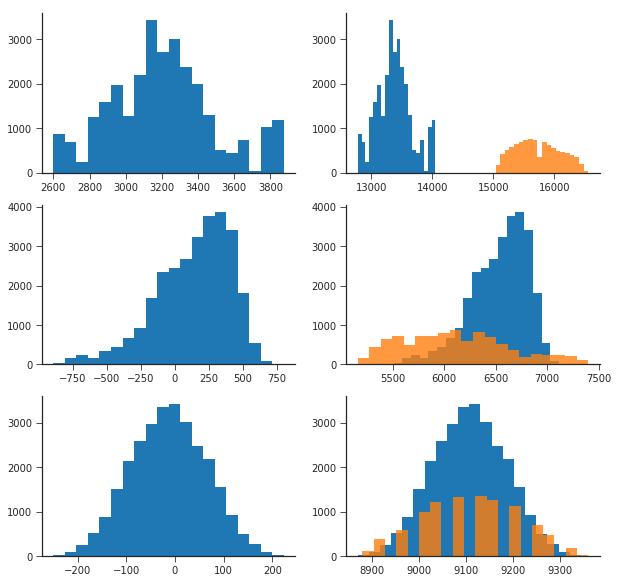

In [155]:
sns.set_style('ticks')
fig = plt.figure(figsize=(10,10))
fig.add_subplot(3,2,1)
plt.hist(drn_cells['x'], bins=20)
fig.add_subplot(3,2,2)
plt.hist(drn_cells['x']+x0,bins=20)
plt.hist(drn_img[0]/0.025, bins=20, alpha=0.8)


fig.add_subplot(3,2,3)
plt.hist(drn_cells['y'], bins=20)
fig.add_subplot(3,2,4)
plt.hist(drn_cells['y']+y0,bins=20)
plt.hist(drn_img[1]/0.025, bins=20, alpha=0.8)


fig.add_subplot(3,2,5)
plt.hist(drn_cells['z'], bins=20)
fig.add_subplot(3,2,6)
plt.hist(drn_cells['z']+z0,bins=20)
plt.hist(drn_img[2]/0.025, bins=20, alpha=0.8)


sns.despine()

### Calculate the center of gravity of whole brain mesh

In [21]:
brain_mesh = io_mesh.load_mesh('/home/julia/data/gradients/atlas/epfl_cell_atlas/mesh_8.ply')

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2444: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:2447: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [22]:
def triangle_area(verts):
    area = abs((verts[0][0]*(verts[1][1]-verts[2][1]) + 
                verts[1][0]*(verts[2][1]-verts[0][1]) + 
                verts[2][0]*(verts[0][1]-verts[1][1])) / 2)
    return area

def triangle_centroid(verts):
    return (verts[0]+verts[1]+verts[2])/3

sum_areas = 0
sum_locations = np.zeros(3)

for face in brain_mesh['faces']:

    verts = brain_mesh['points'][face]
    sum_areas += triangle_area(verts)*2
    sum_locations += triangle_area(verts)*2*triangle_centroid(verts)
    
C = sum_locations/sum_areas

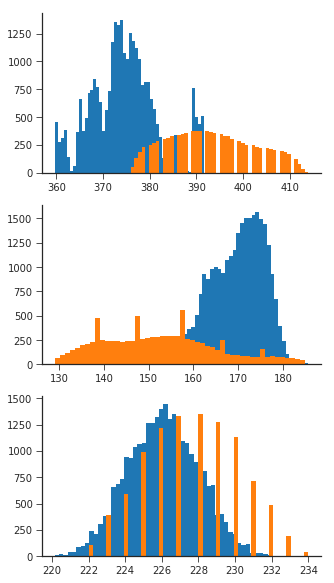

In [26]:
sns.set_style('ticks')
fig = plt.figure(figsize=(5,10))
fig.add_subplot(3,1,1)
plt.hist((drn_cells['x']*0.025)+C[0], bins=50)
plt.hist(drn_img[0], bins=50)


fig.add_subplot(3,1,2)
plt.hist((drn_cells['y']*0.025)+C[1], bins=50)
plt.hist(drn_img[1], bins=50)


fig.add_subplot(3,1,3)
plt.hist((drn_cells['z']*0.025)+C[2], bins=50)
plt.hist(drn_img[2], bins=50)


sns.despine()

### Find neuron closest to origin

In [140]:
# load some of the cell positions
positions = pd.read_csv('/home/julia/data/gradients/atlas/epfl_cell_atlas/positions.txt', 
                        chunksize=10000, 
                        usecols=[0,1,2,3,4], 
                        header=None, 
                        skiprows=1,
                        names=['x', 'y', 'z', 'region', 'type'])

In [132]:
zero_cell = pd.DataFrame()
for chunk in positions:
    zero_cell = zero_cell.append(chunk.loc[np.abs(chunk['x'])<10])
zero_cell = zero_cell.loc[np.abs(zero_cell['y'])<10]
zero_cell = zeroc_cell.loc[np.abs(zero_cell['z'])<10]

In [133]:
zero_cell

,x,y,z,region,type
108177680,-7.04346,-4.02946,7.27882,59,micGl


In [137]:
structure_tree = mcc.get_structure_tree()
origin = structure_tree.get_structures_by_id([59])
print(origin[0]['name'])

Intermediodorsal nucleus of the thalamus


In [138]:
origin_mask, origin_info = mcc.get_structure_mask(59, '/home/julia/data/gradients/atlas/allen_api/origin.nrrd')
nb.Nifti1Image(origin_mask, np.eye(4)).to_filename('/home/julia/data/gradients/atlas/allen_api/origin.nii.gz')

In [139]:
origin_img = np.where(origin_mask==1)

In [141]:
origin_cells = pd.DataFrame()
for chunk in positions:
    origin_cells = origin_cells.append(chunk.loc[chunk['region'] == 59])

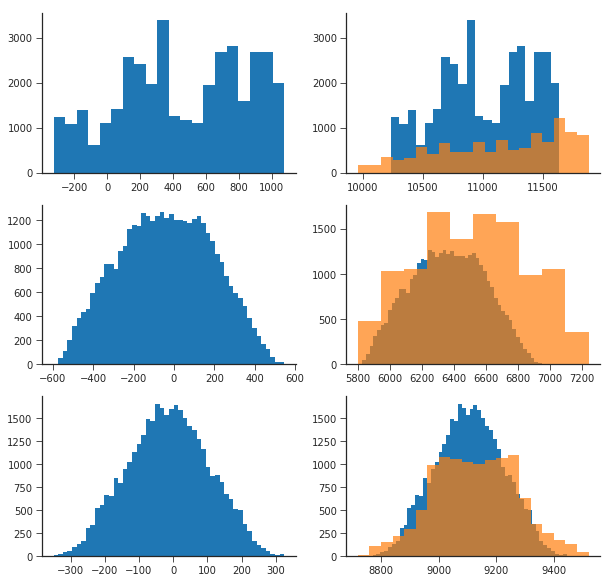

In [151]:
sns.set_style('ticks')
fig = plt.figure(figsize=(10,10))
fig.add_subplot(3,2,1)
plt.hist(origin_cells['x'], bins=20)
fig.add_subplot(3,2,2)
plt.hist(origin_cells['x']+x0,bins=20)
plt.hist(origin_img[0]/0.025, bins=20, alpha=0.7)


fig.add_subplot(3,2,3)
plt.hist(origin_cells['y'], bins=50)
fig.add_subplot(3,2,4)
plt.hist(origin_cells['y']+y0,bins=50)
plt.hist(origin_img[1]/0.025, bins=10, alpha=0.7)


fig.add_subplot(3,2,5)
plt.hist(origin_cells['z'], bins=50)
fig.add_subplot(3,2,6)
plt.hist(origin_cells['z']+z0,bins=50)
plt.hist(origin_img[2]/0.025, bins=20, alpha=0.7)


sns.despine()